# 德国银行信用数据分析（利用MLP）
**马文熙 201870263**  


## 1. Python包导入
数据导入需要用到Pandas，

分割测试集和训练集需要sklearn.model_selection的train_test_split方法，

对数值型特征进行标准化及对分类型特征进行独热编码，需要sklearn.preprocessing的StandardScaler和OneHotEncoder类，

MLP分类器需要用到sklearn.neural_network的MLPClassifier类

测试评估时需要sklearn.metrics的一系列方法，以及Matplotlib进行绘图

超参数调优时需要sklearn.model_selection的GridSearchCV类

In [414]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## 2. 探索性分析
首先将CSV格式的数据导入，查看数据总体情况。可见既有数值型特征，也有分类型特征。

我们的任务是要用前20个特征，预测最后一项标签（customer_type), (1 for good, 2 for bad)

In [415]:
path1 = "german_credit_data_dataset.csv"
data = pd.read_csv(path1)
data.head() # 预览数据

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169.0,A65,A75,4.0,A93,A101,...,A121,67.0,A143,A152,2.0,A173,1,A192,A201,1
1,A12,48,A32,A43,5951.0,A61,A73,2.0,A92,A101,...,A121,22.0,A143,A152,1.0,A173,1,A191,A201,2
2,A14,12,A34,A46,2096.0,A61,A74,2.0,A93,A101,...,A121,49.0,A143,A152,1.0,A172,2,A191,A201,1
3,A11,42,A32,A42,7882.0,A61,A74,2.0,A93,A103,...,A122,45.0,A143,A153,1.0,A173,2,A191,A201,1
4,A11,24,A33,A40,4870.0,A61,A73,3.0,A93,A101,...,A124,53.0,A143,A153,2.0,A173,2,A191,A201,2


In [416]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   checking_account_status  1000 non-null   object 
 1   duration                 1000 non-null   int64  
 2   credit_history           1000 non-null   object 
 3   purpose                  1000 non-null   object 
 4   credit_amount            1000 non-null   float64
 5   savings                  1000 non-null   object 
 6   present_employment       1000 non-null   object 
 7   installment_rate         1000 non-null   float64
 8   personal                 1000 non-null   object 
 9   other_debtors            1000 non-null   object 
 10  present_residence        1000 non-null   float64
 11  property                 1000 non-null   object 
 12  age                      1000 non-null   float64
 13  other_installment_plans  1000 non-null   object 
 14  housing                  

由于分类型特征既有采用字符串表示的，也有采用数字表示的，为了准确辨别，查看各项特征的类别数量，以手动区分

In [417]:
data.nunique()

checking_account_status      4
duration                    33
credit_history               5
purpose                     10
credit_amount              921
savings                      5
present_employment           5
installment_rate             4
personal                     4
other_debtors                3
present_residence            4
property                     4
age                         53
other_installment_plans      3
housing                      3
existing_credits             4
job                          4
dependents                   2
telephone                    2
foreign_worker               2
customer_type                2
dtype: int64

根据结果与实际生活经验，将duration, credit_amount, age三个特征视为数值型特征，其余视为分类型特征

In [418]:
numeric_features_index = ['duration', 'credit_amount', 'age']

## 3. 数据预处理

首先将数据集按照3:1划分为训练集、测试集，再切割为特征和标签

In [419]:
train, test = train_test_split(data, test_size = 0.25, random_state=42)
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

对数值型特征进行均值-方差标准化。为了避免数据泄露，对训练集和测试集分别进行标准化

In [420]:
scaler = StandardScaler()
X_train[numeric_features_index] = scaler.fit_transform(X_train[numeric_features_index])
X_test[numeric_features_index] = scaler.fit_transform(X_test[numeric_features_index])

对分类型数据进行独热编码。

可以看到，最终编码后的特征数量为71个

In [421]:
X_train = pd.get_dummies(X_train, columns=X_train.columns.drop(numeric_features_index))
X_test = pd.get_dummies(X_test, columns=X_test.columns.drop(numeric_features_index))
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 82 to 102
Data columns (total 71 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   duration                      750 non-null    float64
 1   credit_amount                 750 non-null    float64
 2   age                           750 non-null    float64
 3   checking_account_status_A11   750 non-null    uint8  
 4   checking_account_status_A12   750 non-null    uint8  
 5   checking_account_status_A13   750 non-null    uint8  
 6   checking_account_status_A14   750 non-null    uint8  
 7   credit_history_A30            750 non-null    uint8  
 8   credit_history_A31            750 non-null    uint8  
 9   credit_history_A32            750 non-null    uint8  
 10  credit_history_A33            750 non-null    uint8  
 11  credit_history_A34            750 non-null    uint8  
 12  purpose_A40                   750 non-null    uint8  
 13  purp

由于原始数据的标签是Good(1)和Bad(2)，为符合机器学习的惯例，将其修改为Good(0)和Bad(1)

In [422]:
y_train = y_train.apply(lambda x: x - 1)
y_test = y_test.apply(lambda x: x - 1)

## 4. 模型训练及测试

实例化一个MLPClassifier对象，隐藏层定为16-16，最大迭代次数为1000，激活函数为Relu，优化器为Adam

在训练集上进行训练，由于网络结构简单、Adam优化器收敛快，故训练耗时很短

In [423]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(16, 16),
                        max_iter = 1000,activation = 'relu',
                        solver = 'adam')

mlp_clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(16, 16), max_iter=1000)

接下来在测试集上测试表现，Score为0.70

In [424]:
y_pred = mlp_clf.predict(X_test)
print('Prediction Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Prediction Score: 0.70


为了更好地可视化，我们绘制出混淆矩阵

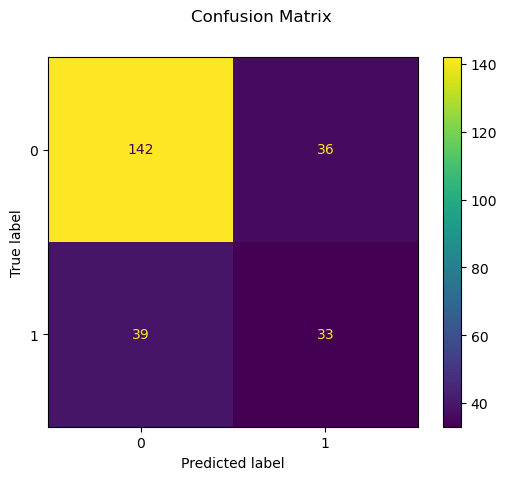

In [425]:
fig = ConfusionMatrixDisplay.from_estimator(mlp_clf, X_test, y_test)
fig.figure_.suptitle("Confusion Matrix")
plt.show()

测试报告如下，可以发现，由于Good(0)的样本数明显多余Bad(1)，因此预测结果更好

In [426]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       178
           1       0.48      0.46      0.47        72

    accuracy                           0.70       250
   macro avg       0.63      0.63      0.63       250
weighted avg       0.70      0.70      0.70       250



收敛曲线绘制如下，可以看到，模型约在500次迭代后收敛

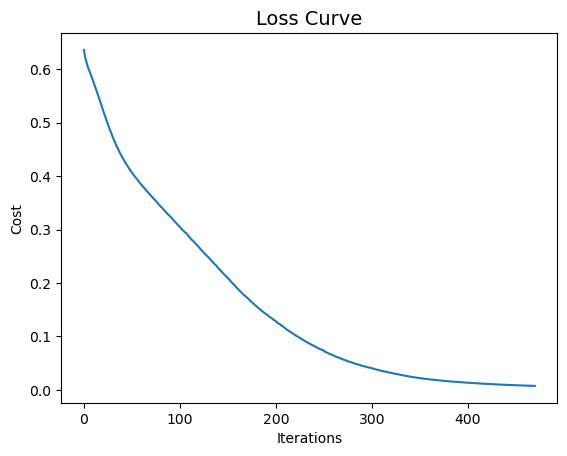

In [427]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## 5. 超参数调优

使用SKLearn的GridSearchCV对超参数进行网格搜索以优化模型。

由于训练所需时间随涉及的参数增加而指数上升，因此分多步搜索。

### 5.1 首先搜索activation (tanh/relu) 和solver (sgd/adam)的组合

In [431]:
param_grid = {
    'hidden_layer_sizes': [(256, 128, 64)],
    'max_iter': [1000],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
}

In [432]:
grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1)
grid.fit(X_train, y_train)

c:\Users\SERN-Portable-neo\anaconda3\envs\data_science\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(16, 16),
                                     max_iter=1000),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(256, 128, 64)],
                         'max_iter': [1000], 'solver': ['sgd', 'adam']})

In [438]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"平均得分: {mean}, 标准差: {stdev}, 参数组合: {param}")

平均得分: 0.7386666666666667, 标准差: 0.048332183894378315, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 1000, 'solver': 'sgd'}
平均得分: 0.724, 标准差: 0.022150996967781552, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 1000, 'solver': 'adam'}
平均得分: 0.7333333333333334, 标准差: 0.029814239699997212, 参数组合: {'activation': 'relu', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 1000, 'solver': 'sgd'}
平均得分: 0.7266666666666666, 标准差: 0.02347575581554535, 参数组合: {'activation': 'relu', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 1000, 'solver': 'adam'}


打印出最佳参数及对应的Score.

可以看到，最佳组合是activation(tanh)+solver(sgd). Score提升到了0.7840

In [601]:
print(grid.best_params_) 
grid_predictions_1 = grid.predict(X_test) 
print('Prediction Score: {:.4f}'.format(accuracy_score(y_test, grid_predictions_1)))

{'activation': 'tanh', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 1000, 'solver': 'sgd'}
Prediction Score: 0.7840


### 5.2 在此基础上搜索隐藏层规模

In [449]:
param_grid_2 = {
    'hidden_layer_sizes': [(512, 64, 8), (256, 128, 64), (192, 128, 32), (128, 64, 8)],
    'max_iter': [2000],
    'activation': ['tanh'],
    'solver': ['sgd'],
}

In [450]:
grid_2 = GridSearchCV(mlp_clf, param_grid_2, n_jobs= -1)
grid_2.fit(X_train, y_train)

c:\Users\SERN-Portable-neo\anaconda3\envs\data_science\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(16, 16),
                                     max_iter=1000),
             n_jobs=-1,
             param_grid={'activation': ['tanh'],
                         'hidden_layer_sizes': [(512, 64, 8), (256, 128, 64),
                                                (192, 128, 32), (128, 64, 8)],
                         'max_iter': [2000], 'solver': ['sgd']})

In [451]:
means = grid_2.cv_results_['mean_test_score']
stds = grid_2.cv_results_['std_test_score']
params = grid_2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"平均得分: {mean}, 标准差: {stdev}, 参数组合: {param}")

平均得分: 0.724, 标准差: 0.024801433650317676, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (512, 64, 8), 'max_iter': 2000, 'solver': 'sgd'}
平均得分: 0.7213333333333334, 标准差: 0.030811253355443588, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 2000, 'solver': 'sgd'}
平均得分: 0.7186666666666667, 标准差: 0.029028721409436332, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (192, 128, 32), 'max_iter': 2000, 'solver': 'sgd'}
平均得分: 0.7226666666666666, 标准差: 0.02254871270038369, 参数组合: {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 8), 'max_iter': 2000, 'solver': 'sgd'}


打印出最佳参数及对应的Score.

可以看到，最佳隐藏层参数是(512, 64, 8). 但Score反而降为0.7760。

可以认为达到了现有数据集规模的拟合极限，故不再搜索参数

In [599]:
print(grid_2.best_params_) 
grid_predictions_2 = grid_2.predict(X_test) 
print('Prediction Score: {:.4f}'.format(accuracy_score(y_test, grid_predictions_2)))

{'activation': 'tanh', 'hidden_layer_sizes': (512, 64, 8), 'max_iter': 2000, 'solver': 'sgd'}
Prediction Score: 0.7760


### 5.3 早停（Early-stopping）以防止过拟合
由于本实验的数据集规模较小，易发生过拟合，因此绘制测试得分曲线，并寻找最佳迭代次数

In [758]:
mlp_clf_3 = MLPClassifier(hidden_layer_sizes=(256, 128, 16),
                        activation = 'tanh',
                        solver = 'sgd')

In [759]:
best_score = 0
best_iter = 0
MAX_PATIENCE = 300
patience_counter = 0
score_list = []
for iter in range(1, 3000):
    mlp_clf_3.partial_fit(X_train, y_train, classes=(0, 1))
    temp_score = mlp_clf_3.score(X_test, y_test)
    score_list.append(temp_score)
    if temp_score > best_score:
        patience_counter = 0
        best_score = temp_score
        best_iter = iter
    else:
        patience_counter += 1
        if patience_counter > MAX_PATIENCE:
            break


可以看到，大约600次迭代比较合理

In [760]:
print("Best iteration: ", best_iter, " Best score: ", best_score)

Best iteration:  487  Best score:  0.78


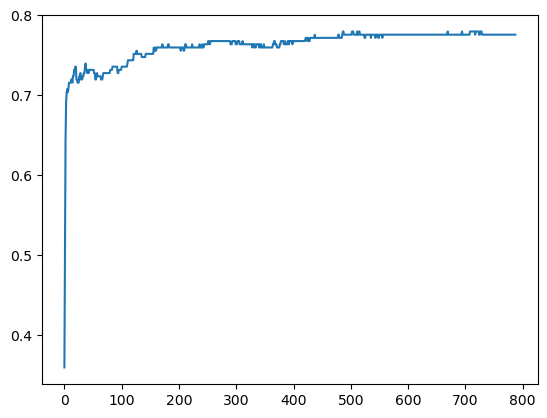

In [761]:
plt.plot(score_list)

### 5.4 最佳结果

In [766]:
mlp_clf_best = MLPClassifier(hidden_layer_sizes=(256, 128, 16),
                        activation = 'tanh',
                        solver = 'sgd',
                        max_iter=600)

mlp_clf_best.fit(X_train, y_train)

c:\Users\SERN-Portable-neo\anaconda3\envs\data_science\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(256, 128, 16),
              max_iter=600, solver='sgd')

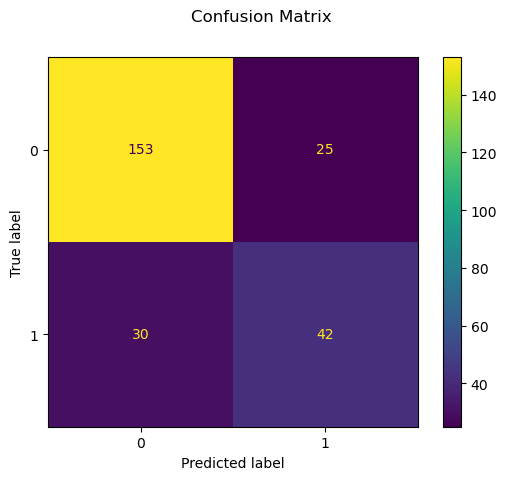

In [767]:
fig = ConfusionMatrixDisplay.from_estimator(mlp_clf_best, X_test, y_test)
fig.figure_.suptitle("Confusion Matrix")
plt.show()

In [768]:
y_pred_best = mlp_clf_best.predict(X_test)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       178
           1       0.63      0.58      0.60        72

    accuracy                           0.78       250
   macro avg       0.73      0.72      0.73       250
weighted avg       0.78      0.78      0.78       250



In [765]:
print('Prediction Score: {:.4f}'.format(accuracy_score(y_test, y_pred_best)))

Prediction Score: 0.7840


本报告到此结束